In [1]:
using Revise, Plots, LinearAlgebra, LaTeXStrings, Random, Plots.Measures

In [2]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

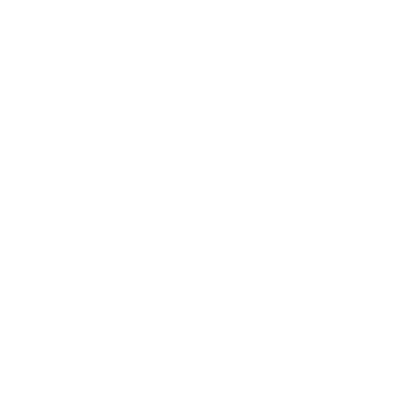

In [4]:
n_coarse_grid = 11
n_plt_grid = 101

coarse_grids = grid(domain, n_coarse_grid)
plt_grids = grid(domain, n_plt_grid)
hm_grid = grid(domain[1], n_plt_grid)

plot_size = (400, 400) .* 2
plt = heatmap(xlims=domain[1], ylims=domain[2],
legend=:none, grid=false, ticks=:none, ratio=:equal,
    cb=:none, size=(400, 400), margins=-2mm, frame=:none)

In [5]:
ops = gaussian_operators_2D(0.08, coarse_grids)

Operators(var"#ϕ#32"{Int64}(Core.Box(var"#gauss2D#31"{Float64, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64}(0.24867959858108651, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.1 0.0; … ; 0.9 1.0; 1.0 1.0], 78.125)), 121), var"#Φ#33"{var"#ϕ#32"{Int64}, Int64}(var"#ϕ#32"{Int64}(Core.Box(var"#gauss2D#31"{Float64, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64}(0.24867959858108651, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.1 0.0; … ; 0.9 1.0; 1.0 1.0], 78.125)), 121), Core.Box(var"#gauss2D#31"{Float64, Vector{Float64}, Vector{Float64}, 

## Pre-certificate

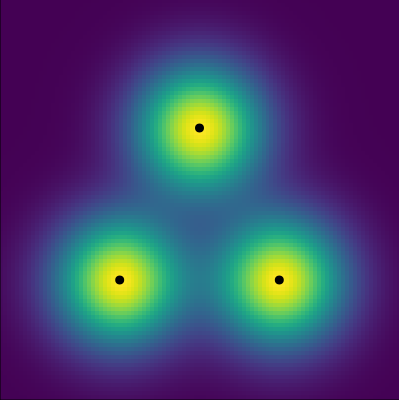

In [ ]:
x0 = [[0.3, 0.5, 0.7], [0.3, 0.68, 0.3]]
a0 = [1.0, 1.0, 1.0]

μ0 = DiscreteMeasure(x0, a0)

ηV = build_ηV(μ0, ops, plt_grids)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, hm_grid, hm_grid, ηV, color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", colorscheme=get_cmap(:red_black))

### SFW

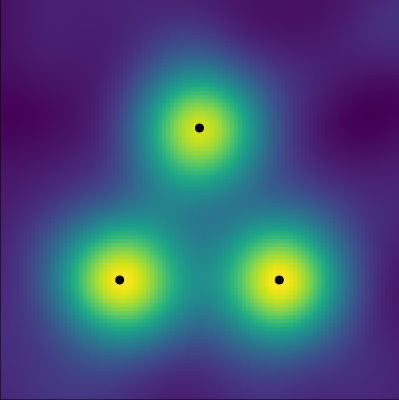

In [ ]:
y0 = ops.Φ(μ0...)

function add_noise(y0, noise_level)
    sigma = noise_level * norm(y0)
    w = randn(length(y0))
    w = w / norm(w) * sigma
    y = y0 + w
    return y
end

# Add noise to the observation y = y0 + w
noise_level = 0.2
y = add_noise(y0, noise_level)
δ = noise_level * norm(y)

plt_obs = deepcopy(plt)

heatmap!(plt_obs, hm_grid, hm_grid, ops.adjΦ(y, grids=plt_grids), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", colorscheme=get_cmap(:red_black))

In [54]:
plt_cert_behav = deepcopy(plt_obs)

prob = BLASSO(y, ops, domain, n_coarse_grid)
solve!(prob, :MDP, options=Dict(:store_reg_path => true, :maxits => 40, :δ => δ, :τδ => 0.85δ, :q => 0.9))
plot_spikes!(plt_cert_behav, prob.μ, label=L"\hat{μ}", marker=:x, colorscheme=get_cmap(:red_black), markersize=7, markerstrokewidth=2)

## Figures

Make plots demonstrating sparsity of solution according to $\lambda$.

In [ ]:
λ = λ₀(coarse_grids, ops.ϕ, y) - eps(Float64)
λ /= 10
λ /= 2

plt_sparse = deepcopy(plt_obs)

prob_sparse = deepcopy(prob)
prob_sparse.μ = nothing
prob_sparse.λ = λ
solve!(prob_sparse, :SFW)

plot_spikes!(plt_sparse, prob_sparse.μ,  marker=:x, colorscheme=get_cmap(:red_black), markersize=7, markerstrokewidth=2)

In [12]:
# savefig(plt_sparse, "../figures/Morozov/Poster/Too_big_λ.svg")
# savefig(plt_sparse, "../figures/Morozov/Poster/Optimal_λ.svg")
# savefig(plt_sparse, "../figures/Morozov/Poster/Too_small_λ.svg")

In [ ]:
λs = prob.reg_path[:λs]
rs = [norm(ops.Φ(μ...) - y) for μ in prob.reg_path[:μs]];

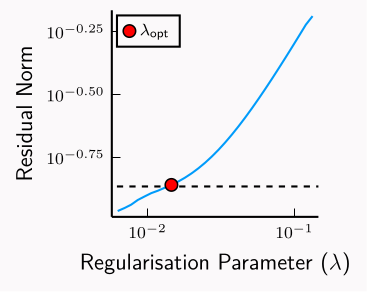

In [64]:
pgfplotsx()
using PGFPlotsX

empty!(PGFPlotsX.CUSTOM_PREAMBLE)
push!(PGFPlotsX.CUSTOM_PREAMBLE,raw"""
\usepackage[T1]{fontenc}
\usepackage{lmodern}
\renewcommand{\familydefault}{\sfdefault} % make all text sans-serif
"""
)

p = plot(λs, rs,
    xaxis=:log10, yaxis=:log10,# ylims=(0.02, 1),
    xlabel=L"Regularisation Parameter ($\lambda$)", ylabel="Residual Norm",
    label="", marker=:circle, markersize=0, grid=:none, size=(200, 200),
    xticks=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    # yticks=[0.1, 1, 10],
    bg=Colors.RGB(251 / 255, 249 / 255, 250 / 255),
    fg=:black,
    )
hline!([1.05 * δ], linestyle=:dash, color=:black, label="")
scatter!([λs[22]], [rs[22]], label=LaTeXStrings.L"\lambda_\mathsf{opt}", legend=:topleft, color=:red)
plot!(p, margins=0mm)

In [15]:
# savefig(p, "../figures/Morozov/Poster/MDP_purple.svg")